In [1]:
from heuristics_constructive import Random as ConstructiveRandom
from math import inf
from uuid import uuid4
from moveSelectionStrategy import RandomFirst
from heuristics_improvement import Taboo
import matplotlib.pyplot as plt
from paintshop import PaintShop, Source
from os import path
from cache import save, ensuredir, load, cache_file_exists
from heuristics_improvement import HeuristicRunData

### Initialize the PaintShop instance and the contructive heuristic instance (generator)

In [2]:
ps = PaintShop(Source.NOVEMBER)
generator = ConstructiveRandom(ps)

[PaintShop] Loaded 'resources\PaintShop - November 2024.xlsx'


### Settings

In [3]:
# from heuristics_improvement import ImprovementHeuristics

# Enter a run ID to load existing run.
# race_id = '2216673a-c085-42be-b6bd-bc97ccbbf341' # 15 minute runs
# race_id = '54e67de2-617e-4bcb-9628-2538ca0cae3d' # 60 minute runs
race_id = 'df689ce4-a380-4c98-bb62-cc5cee598d06' # Annealing comparisons

# Create a new run
# race_id = str(uuid4())

from os import path
from moveSelectionStrategy import MoveSelectionStrategies
from heuristics_improvement import Annealing, HeuristicRunData, Basic, ImprovementHeuristic, Taboo

run_minutes = 30
# run_minutes = 0.5
t_run_max = 60*run_minutes
n_runs_per_improver = 2

ensuredir('races')
runs_dir = path.join('races', race_id)
ensuredir(runs_dir)


# improvers: list[ImprovementHeuristic] = [
#     Basic(MoveSelectionStrategies.random),
#     Basic(MoveSelectionStrategies.best),
#     Taboo(MoveSelectionStrategies.random, MoveSelectionStrategies.random),
#     # Annealing(20000, 250),
#     Annealing(250000, 250),
#     Annealing(250000, 50) # Can do about 150000 iterations in 15 minutes
# ]
improvers: list[ImprovementHeuristic] = [
    Annealing(250),
    Annealing(100),
    Annealing(50),
    Annealing(25),
    Annealing(10),
    Annealing(5)
]

In [4]:
from time import time

from heuristics_constructive import ConstructiveHeuristic


def run_until(improver: ImprovementHeuristic, generator: ConstructiveHeuristic, t_max: int, verbosity: 0|1|2 = 1) -> HeuristicRunData:
    
    t0 = time()
    race_run: HeuristicRunData = None
    
    # Do runs untill time limit
    while (time() - t0) < t_max:
        run: HeuristicRunData = improver.run(generator.generate(), verbosity = verbosity, t0 = t0, t_max = t_max)
        
        if race_run is None:
            race_run = run
        else:
            # Update total_run (TODO: maybe implement __add__)
            race_run.last = run.last
            race_run.iterations += run.iterations
            if run.best.cost < race_run.best.cost:
                race_run.best = run.best
        
    return race_run

### Do races

In [5]:
from cache import cache_dir_exists

for race_i in range(n_runs_per_improver):
    
    # Race Directory
    race_dir =  path.join(runs_dir, str(race_i))
    ensuredir(race_dir)
    
    for improver in improvers:
        
        # Improver Directory
        run_dir = path.join(race_dir, str(improver))
        ensuredir(run_dir)
        
        # Run file
        run_data_path  = path.join(run_dir, f"run_data")
        print(f'[{race_i}]{improver}:')
        
        # If no file:
        if not cache_file_exists(run_data_path):
            
            # Initialize
            print(f"Running for {t_run_max}s")
            run_data = improver.run_timed(
                HeuristicRunData(improver, generator.generate()), 
                t_run_max, 
                verbosity = 1, 
                t0 = time()
            )
            
            # Save run
            save(run_data, run_data_path)
        
        else:
            print(f'Found.\n')
        # # File exists:
        # else:
            
        #     # Load run
        #     run_data: HeuristicRunData = load(run_data_path)
            
        #     # If run not done:
        #     if run_data.iterations[-1].time < t_run_max:
                
        #         # Continue run
        #         print(f"Incomplete run, continuing from {run_data.iterations[-1].time}s to {t_run_max}s ({t_run_max - run_data.iterations[-1].time}s)")
        #         run_data = improver.run_timed(
        #             run_data, 
        #             t_run_max,
        #             verbosity = 1, 
        #             t0 = time() - run_data.iterations[-1].time
        #         )
                
        #         # Save run
        #         save(run_data, run_data_path, overwrite = True)

[0]annealing_250:
Found.

[0]annealing_100:
Found.

[0]annealing_50:
Found.

[0]annealing_25:
Found.

[0]annealing_10:
Found.

[0]annealing_5:
Found.

[1]annealing_250:
Found.

[1]annealing_100:
Found.

[1]annealing_50:
Found.

[1]annealing_25:
Found.

[1]annealing_10:
Found.

[1]annealing_5:
Found.



### Plot run

### Plot best

In [6]:
from cache import cache_list_dir


races = cache_list_dir(runs_dir)

for race in races:
    print(f"Race {race}:\n")
    race_dir = path.join(runs_dir, race)
    race_runs = cache_list_dir(race_dir)
    for improver in race_runs:
        run_file = path.join(race_dir, improver, 'run_data')
        run_data: HeuristicRunData = load(run_file)
        print(run_data.best)
        print()

Race 0:

Loaded: 'cache\races\df689ce4-a380-4c98-bb62-cc5cee598d06\0\annealing_10\run_data.pickle'.
    |  0   1   2   3   4   5   6   7   8   9  10  11  12 | 9198.41 ✔
M1: |  0   3   7   8  11  26  29  33  38  41             | 1410.00 (15%)
M2: | 10  13  16  20  21  31  34  36  42  44  45         | 361.00  (4%)
M3: |  2   4  15  17  18  19  25  27  28  30  37  39  40 | 3828.29 (42%)
M4: |  1   5   6   9  12  14  22  23  24  32  35  43     | 3599.12 (39%)

Loaded: 'cache\races\df689ce4-a380-4c98-bb62-cc5cee598d06\0\annealing_100\run_data.pickle'.
    |  0   1   2   3   4   5   6   7   8   9  10  11  12 | 8975.82 ✔
M1: |  3   4   6  11  12  16  19  24  35  37  45         | 1456.50 (16%)
M2: |  8  13  14  15  18  29  30  40  43  44             | 1219.50 (14%)
M3: |  0   1   5   7   9  17  22  23  25  27  33  38  42 | 3798.12 (42%)
M4: |  2  10  20  21  26  28  31  32  34  36  39  41     | 2501.71 (28%)

Loaded: 'cache\races\df689ce4-a380-4c98-bb62-cc5cee598d06\0\annealing_25\run_data.pic

Loaded: 'cache\races\df689ce4-a380-4c98-bb62-cc5cee598d06\0\annealing_10\run_data.pickle'.


AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

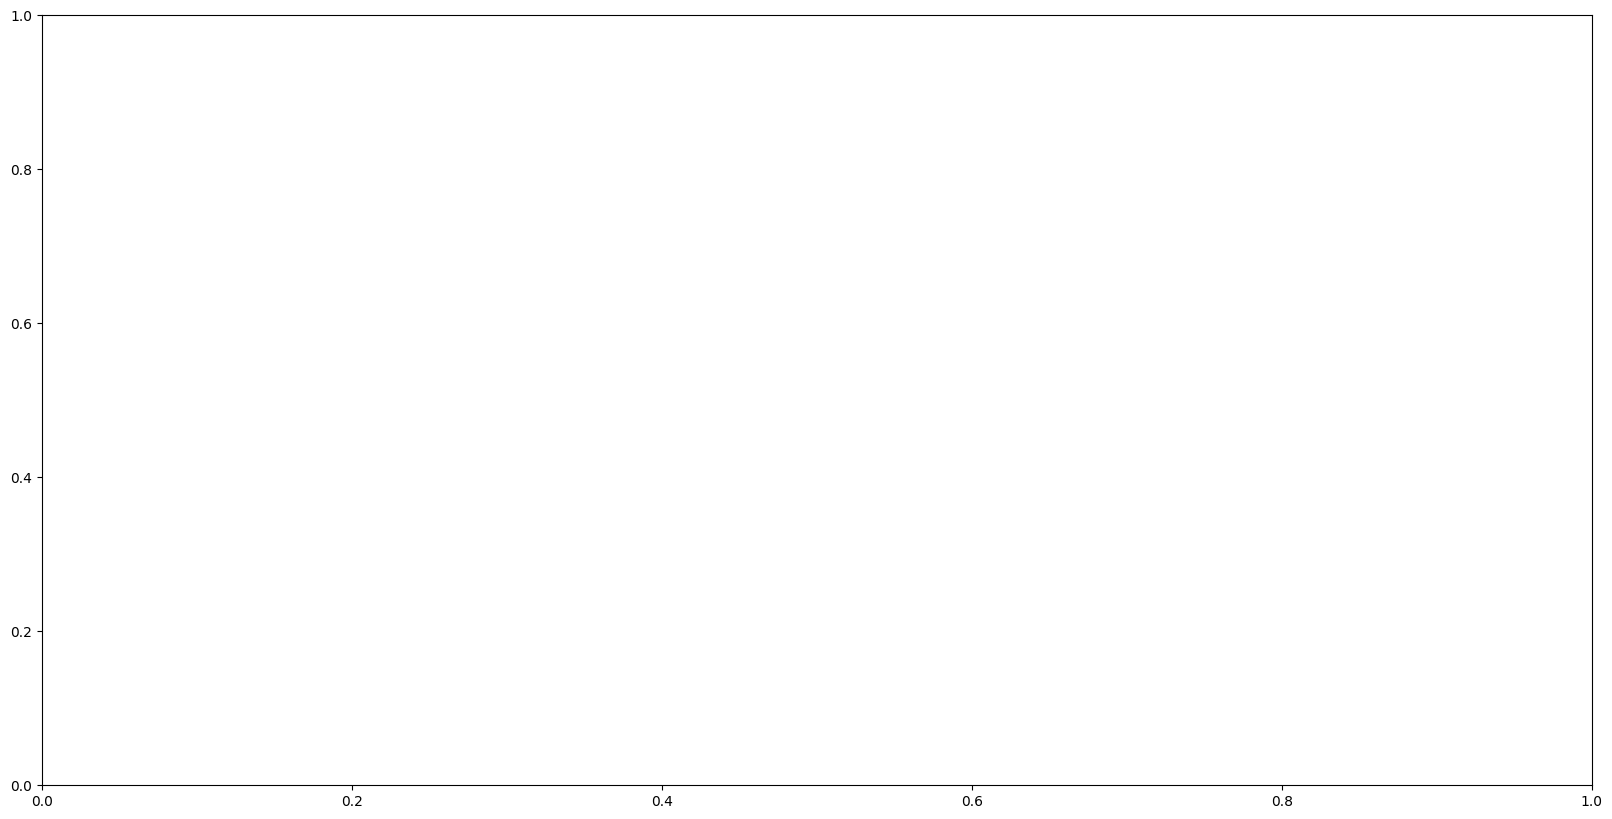

In [7]:
plt.figure(figsize=(20,10))

improver_colors = {}

for race in races:
    race_dir = path.join(runs_dir, race)
    race_runs = cache_list_dir(race_dir)
    for improver in race_runs:
        run_file = path.join(race_dir, improver, 'run_data')
        run_data: HeuristicRunData = load(run_file)
        
        if improver in improver_colors:
            color = improver_colors[improver]
            first_run_of_improver = False
        else:
            color = next(plt.gca()._get_lines.prop_cycler)['color']
            # color = next(plt.gca()._get_lines.color_cycle)
            improver_colors[improver] = color
            first_run_of_improver = True
        
        # Calculate running best
        running_best_cost = []
        for i in run_data.iterations:
            if len(running_best_cost) < 1 or i.cost < running_best_cost[-1]:
                running_best_cost.append(i.cost)
            else:
                running_best_cost.append(running_best_cost[-1])

        # plt.plot([iter.time for iter in run_data.iterations], [iter.cost for iter in run_data.iterations], '.', label = f'{run}', color = color)
        if first_run_of_improver:
            plt.plot([iter.time for iter in run_data.iterations], running_best_cost, linewidth = 2, alpha = 1, color = color, label = f'{improver}')
        else:
            plt.plot([iter.time for iter in run_data.iterations], running_best_cost, linewidth = 2, alpha = 1, color = color)
        
        
plt.xlabel('Cumulative processing time (s)')
plt.ylabel('Best solution cost')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

### Plot running best against time spent

In [8]:
from cache import cache_list_dir

plt.figure(figsize=(20,10))

for run_id in cache_list_dir(runs_dir):
    run_data: HeuristicRunData = load(path.join(runs_dir, run_id, 'run_data'))
    print()

    running_times = []
    for i, iter in enumerate(run_data.iterations):
        if i == 0:
            running_times += [iter.time]
            continue
        running_times += [iter.time + running_times[i - 1]]


    plt.plot(running_times, running_best_cost, linewidth = 2)


plt.xlabel('Cumulative processing time (s)')
plt.ylabel('Best solution cost')
plt.grid()
plt.yscale('log')
plt.xscale('log')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'cache\\races\\df689ce4-a380-4c98-bb62-cc5cee598d06\\0\\run_data.pickle'

<Figure size 2000x1000 with 0 Axes>

### Iteration vs Iteration time

In [15]:
from numpy import cumsum


plt.figure(figsize=(20,10))
plt.plot(iterations, [i.time for i in run_data.iterations], linewidth = 0.2)
# plt.plot(iterations, cumsum([i.time for i in run_data.iterations]), linewidth = 2)
plt.xlabel('Iteration')
plt.ylabel('Iteration processing time')
plt.grid()
# plt.yscale('log')
# plt.xscale('log')

NameError: name 'iterations' is not defined

<Figure size 2000x1000 with 0 Axes>

# Classes

Metaheuristics:
- Multistart:  Improving multiple starts and take the best local optimum
- Taboo Search: Reverse steps are forbidden (taboo-list). Tabu moves are removed from the list after a number of moves. Stop at a certain number of iterations OR when all available moves are taboo. Keep track of incumbent solution.
- Simulated Annealing: Temperature & cooling schedule. Allways accepts improving moves. Non-improving moves with probablity based on the obj. improvement and temperature. Randomly choose a move, compute the gain. If it improves, accept, otherwise accept with probability e^(delta_obj / q). Update incumbent solution. Reduce temperature q. See graph in slides.
- Genetic algorithms: Many different ideas. Population of solutions.
   - Start with a number of random solutions.
   - Create new solutions by combining pairs.
   - Mutations sometimes.
   - Select survivors (elite).



# Solution

In [60]:
import math
import time

def heuristic_improvement_comparison_multistart(n_starts, constructive_heuristic: ConstructiveHeuristic, improvement_heuristic: ImprovementStrategy) -> list[dict]:
    
    # Generate n_starts random feasible solutions, initialize a list of dictionaries to keep track of things.
    starting_schedules: list[Schedule] = [constructive_heuristic.get_schedule() for _ in range(n_starts)]
    runs_data = [
        {
            "incumbent": schedule,
            "imcumbent_cost": schedule.get_cost(),
            "history": [],
            "done": False,
        } for schedule in starting_schedules
    ]
    
    print(f"Generated {n_starts} schedules.")
    print(f"Starting improvement heuristic...")
    
    # Heuristic loop
    iteration_count = 0
    while any([(not run["done"]) for run in runs_data]):
        
        iteration_count += 1
        
        # For each run
        for run_index in range(n_starts):
                        
            # If the run is done, do nothing
            if runs_data[run_index]["done"]:
                continue
            
            t0 = time.time()
            
            # Get the first improving feasible move
            move: Move
            moved_schedule: Schedule
            move, moved_schedule = improvement_heuristic.get_improvement(runs_data[run_index]["incumbent"])
            
            # If terminated, set done and continue
            if move is None:
                runs_data[run_index]["done"] = True
                continue
                        
            # Update schedule, add history entry
            runs_data[run_index]["incumbent"] = moved_schedule
            # Create history entry
            runs_data[run_index]["history"] += [{
                "processing_time": time.time() - t0,
                "move": move,
                "cost": moved_schedule.get_cost()
            }]
        
        
        # Print progress
        cur_penalties = [data['history'][-1]["cost"] for data in runs_data]
        cur_times = [data['history'][-1]["processing_time"] for data in runs_data]
        print(f"{iteration_count}: {sum([1 for run in runs_data if not run['done']])}/{n_starts} | {np.mean(cur_penalties):.0f} ± {np.std(cur_penalties):.0f} ({sum(cur_times):.2f}s)")
    
    # Print completion
    print(f'No improving moves found.')
    return (iteration_count, runs_data)




NameError: name 'ConstructiveHeuristic' is not defined

In [13]:
def discrete_improvement_run(constructive_heuristic: ConstructiveHeuristic, improvement_strategy: ImprovementStrategy):
    
    start: Schedule = constructive_heuristic.get_schedule()
    data = {
        "incumbent": start,
        "iteration_count": 0,
        "history": [],
    }
    
    
    iteration_count = 0
    while True:
        
        
        t0 = time.time()
        
        # Get the first improving feasible move
        move: Move
        moved_schedule: Schedule
        move, moved_schedule = improvement_strategy.get_improvement(data["incumbent"], Move.get_moves(data["incumbent"]))

        if (move is None):
            break
        
        # Create history entry
        data["history"] += [{
            "processing_time": time.time() - t0,
            "move": move,
            "cost": moved_schedule.get_cost()
        }]
        
        #
        iteration_count += 1
        
        # Update schedule, add history entry
        data["incumbent"] = moved_schedule
        
    data["iteration_count"] = iteration_count
    
    return data

In [14]:
from matplotlib.axes import Axes
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
def plot_multistart(runs, constructive: ConstructiveHeuristic, improvement: ImprovementStrategy):
    
    iter_count = max([run["iteration_count"] for run in runs])
    
    iterations = range(iter_count - 1)
    
    iteration_costs = [
        [
            run["history"][i]["cost"] for run in runs if i < len(run["history"])
        ] for i in iterations
    ]
    
    penalty_means = np.array([
        np.mean([ic]) for ic in iteration_costs
    ])
    penalty_stds = np.array([
        np.std([ic]) for ic in iteration_costs
    ])

    best_run_index = sorted(range(len(runs)), key = lambda ri: runs[ri]["history"][-1]["cost"])[0]
    best_run = runs[best_run_index]
    
    # Create figure grid
    trackplot: Axes
    spreadplot: Axes
    fig, (trackplot, spreadplot) = plt.subplots(1, 2, figsize = (20,6))
    fig.suptitle(f"{improvement.name_display}: {len(runs)}x {constructive.name_display} multistart")
    
    # Trackplot
    best_plot_trackplot: Line2D
    run_trackplot: Line2D
    for ri, run in enumerate(runs):
        if ri != best_run_index:
            run_trackplot = trackplot.plot(
                range(len(run["history"])), 
                [entry['cost'] for entry in run["history"]],
                # linewidth = 3 if (ri == best_run_index) else 1
                linewidth = 2,
                alpha = .2,
            )[0]
            trackplot.plot(
                [len(run["history"]) - 1], 
                [run["history"][-1]["cost"]],
                # linewidth = 3 if (ri == best_run_index) else 1
                markersize = 3,
                marker = "o",
                alpha = 1,
                color = run_trackplot.get_color()
            )[0]
            
    # Best run
    best_plot_trackplot = trackplot.plot(
        range(len(best_run["history"])), 
        [entry['cost'] for entry in best_run["history"]],
        # linewidth = 3 if (ri == best_run_index) else 1
        linewidth = 3,
        alpha = 1,
        label = "Best run",
        color = 'black'
    )[0]
    trackplot.plot(
        [len(best_run["history"]) - 1], 
        [best_run["history"][-1]["cost"]],
        # linewidth = 3 if (ri == best_run_index) else 1
        markersize = 3,
        marker = "o",
        alpha = 1,
        color = best_plot_trackplot.get_color()
    )[0]
            
            
    trackplot.set_title("Runs")
    trackplot.set_yscale('log')
    y_max = max([run['history'][0]['cost'] for run in runs])
    trackplot.set_ylim(0, y_max)
    trackplot.set_xlim(0, None)
    trackplot.set_ylabel("Penalty (log)")
    trackplot.set_xlabel("Iterations")
    trackplot.legend()
    # trackplot.grid(True, 'minor')
    
    # Spreadplot
    spreadplot.fill_between(iterations, penalty_means - penalty_stds, penalty_means + penalty_stds, alpha = 0.3, label = "μ±σ")
    spreadplot.plot(iterations, penalty_means, label='μ')
    spreadplot.plot(
        range(len(runs[best_run_index]["history"])), 
        [entry['cost'] for entry in runs[best_run_index]["history"]], 
        label = f"best run\n({runs[best_run_index]['history'][-1]['cost']:.2f})", 
        color = best_plot_trackplot.get_color(),
        linewidth = 3,
    )
    
    # Best
    spreadplot.plot(
        [len(runs[best_run_index]["history"]) - 1], 
        [runs[best_run_index]["history"][-1]["cost"]],
        # linewidth = 3 if (ri == best_run_index) else 1
        markersize = 6,
        marker = "o",
        alpha = 1,
        color = best_plot_trackplot.get_color()
    )
    
    # Done
    spreadplot.plot(
        iterations, 
        [sum([y_max/len(runs) for run in runs if run["iteration_count"] <= i]) for i in iterations],
        # linewidth = 3 if (ri == best_run_index) else 1
        markersize = 6,
        alpha = 1,
        label = "% terminated"
    )
    
    # spreadplot.set_title(f"First improvement: {len(runs)}x random multistart")
    spreadplot.legend()
    spreadplot.set_yscale('log')
    spreadplot.set_ylim(0, max([run['history'][0]['cost'] for run in runs]))
    spreadplot.set_ylabel("Penalty (log)")
    spreadplot.set_xlabel("Iterations")
    # spreadplot.grid(True, 'minor')
    
    plt.show()
    

In [15]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    print(f"Saved: '{filename}'")

In [ ]:
n_runs = 200
constructive = Heuristics.Contructive.random
# improvement = Heuristics.Improvement.first
improvement = Heuristics.Improvement.best
# (iter_count, runs) = heuristic_improvement_comparison_multistart(n_runs, constructive, improvement)

import uuid
import os

cache_folder = f"multistart_{constructive.name}_{improvement.name}"

for ri in range(n_runs):
    
    run_data = discrete_improvement_run(constructive, improvement)
    
    print(f"Run terminated at {run_data['history'][-1]['cost']:.0f} after {run_data['iteration_count']} iterations. ({sum([data['processing_time'] for data in run_data['history']]):.1f}s)")
    
    if not os.path.exists(cache_folder):
        os.mkdir(cache_folder)
    
    # Save with random uuid
    save_object(run_data, os.path.join(cache_folder, f'{uuid.uuid4()}.pkl'))

In [ ]:
race_runs = []
for run_data_path in os.listdir(cache_folder):
    with open(os.path.join(cache_folder, run_data_path),'rb') as file:
        race_runs += [pickle.load(file)]
        
plot_multistart(race_runs, constructive, improvement)

In [ ]:
constructive = Heuristics.Contructive.random
improvement = Heuristics.Improvement.first
cache_folder = f"multistart_{constructive.name}_{improvement.name}"

# Load runs
race_runs = []
for run_data_path in os.listdir(cache_folder):
    with open(os.path.join(cache_folder, run_data_path),'rb') as file:
        race_runs += [pickle.load(file)]
        
# Plot multistart
plot_multistart(race_runs, constructive, improvement)

In [ ]:
best_run_index = sorted(range(len(race_runs)), key = lambda ri: race_runs[ri]["history"][-1]["cost"])[0]
best_run = race_runs[best_run_index]
best_run_schedule: Schedule = best_run["incumbent"]
print(best_run_schedule)
best_run_schedule.draw()

In [ ]:
# import matplotlib.animation as animation

# def plot_multistart_animation(n_runs: int, constructive_heuristic: Callable[[], Schedule], improvement_heuristic: Callable[[Schedule], Move]) -> None:
    
#     # Initialize plot
#     plt.ion()
#     fig, ax = plt.subplots()

#     # List of runs data
#     runs = [{
#         "hist_schedule": [schedule],
#         "hist_penalty": [cost],
#         "hist_move": [],
#         "done": False,
#         "line": plt.plot([0], [cost], lw = 2)[0]
#     } for schedule, cost in 
#         [
#             (schedule, schedule.get_cost()) for schedule in 
#             [constructive_heuristic() for _ in range(n_runs)]
#         ]
#     ]
    
        
    
#     plt.ylim(0, max([run["hist_penalty"][-1] for run in runs]))
#     plt.pause(1)
#     # plt.autoscale(True)
#     # plt.show()
    
#     print(f"Generated {n_runs} initial schedules.")
#     print(f"Starting improvement heuristic.")
    
#     # Heuristic loop, do until all runs are done
#     iter_count = 0
#     while any([not run["done"] for run in runs]):
    
        
#         iter_count += 1
#         print(f"Iteration {iter_count}:")
        
#         # For each run
#         for ri in range(n_runs):
            
#             # If the run is done: skip
#             if runs[ri]["done"]:
#                 continue
            
#             # Get the move according to the specified improvement heuristic
#             move = improvement_heuristic(runs[ri]["hist_schedule"][-1])
            
                        
#             # Check if no improving move was found
#             if move is None:
#                 runs[ri]["done"] = True
#                 print(f"Run {ri}: No improvement found.")
#                 continue
    
#             # Apply move, add to history
#             moved_schedule = move.get_moved(runs[ri]["hist_schedule"][-1])
#             moved_cost = moved_schedule.get_cost()
#             runs[ri]["hist_schedule"] += [moved_schedule]
#             runs[ri]["hist_penalty"] += [moved_cost]
            
#             print(f"Run {ri}: {moved_cost:.0f} ({move})")
            
#             # Update plot
            
#             # removing the older graph
#             runs[ri]["line"].remove()
#             runs[ri]["line"] = plt.plot(range(len(runs[ri]["hist_penalty"])), runs[ri]["hist_penalty"])[0]
            
#             plt.pause(0.25)
            
#             # runs[ri]["line"].set_xdata(np.array(range(len(runs[ri]["hist_penalty"]))))
#             # runs[ri]["line"].set_ydata(np.array(runs[ri]["hist_penalty"]))
            

# Code Validation

In [12]:
import itertools as iter

### Move-set redundancy
Ensuring that no two moves produce the same moved schedules.

In [ ]:
# Generate and display a random schedule
s = heuristic_constructive_random()
print(s)

# Generate all possible moves and print the amount
moves: list[Move] = Move.get_moves(s)
print(f'\nAmount of moves: {len(moves)}')

# Generate the moved schedules for all the moves
moved_schedules = [move.get_moved(s) for move in moves]
print(f"\nMoves that do nothing: {sum([(s == moved_s) for moved_s in moved_schedules])}")

# Display the amount of unique moved schedules
print(f'\nUnique schedules after moves: {len(set(moved_schedules))}')

# Create a dictionary of moves by the hash-code of the moved schedule that they produce
by_hash = {}
for move in moves:
    
    # Get moved schedule
    moved = move.get_moved(s)
    
    # Get hash-code
    hash_code = hash(moved)
    
    # Add move if hash-code exists in dict, else: add it.
    if hash_code in by_hash.keys():
        by_hash[hash_code]["moves"] += [move]
    else:
        by_hash[hash_code] = {
            "moves": [move],
            "schedule": moved
        }
        
# Display all the non-unique moved schedules along with their moves
for hash_code, data in [(hash_code, data) for hash_code, data in by_hash.items() if len(data["moves"]) > 1]:
    print()
    print(data["schedule"])
    for move in data["moves"]:
        print(move)